In [ ]:
import pandas as pd
import os
import requests
import shelve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
import statsmodels 
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.runs import runstest_1samp
import glob

from pathlib import Path

In [ ]:
user="lholguin"
years_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
#user in personal pc1 <- "asus"

#### Generating some stats and Runs Test for the panels

Doing the statistical analysis. Be careful with the units scale

In [ ]:
class NDCATC_stats:  #Creating a new class to analyze correlations
    
    @staticmethod 
    def correlation_look(years_list, base_path=None, min_records=8, state_filter=None):
        
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("CORRELATION ANALYSIS: Units Reimbursed vs Number of Prescriptions")
        print("THREE-PANEL ANALYSIS")
        print("="*70)
        
        results = {
            'panel1_state_atc2': [],
            'panel2_national_atc2': [], 
            'panel3_atc2_quarter': []
        }
        
        # Load all data first
        all_data = {}
        for year in years_list:
            print(f"Loading {year} data...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                records['ATC2 Class'] = records['ATC4 Class'].str[:3]
                all_data[year] = records
                print(f"✓ ({len(records):,} records)")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        # ==================== PANEL 1: STATE x ATC2 ANALYSIS ====================
        print(f"\n{'='*70}")
        if state_filter:
            print(f"PANEL 1: {state_filter} STATE x ATC2 CORRELATION ANALYSIS")
        else:
            print("PANEL 1: STATE x ATC2 CORRELATION ANALYSIS")
        print(f"{'='*70}")
        
        # Combine all years first
        all_combined = []
        for year, records in all_data.items():
            records_copy = records.copy()
            records_copy['Year'] = year
            all_combined.append(records_copy)
        
        combined_df = pd.concat(all_combined, ignore_index=True)
        
        # Apply state filter for Panel 1
        if state_filter:
            panel1_states = [state_filter]
        else:
            panel1_states = combined_df['State'].unique()
        
        # Now analyze across all years
        for state in panel1_states:
            state_data = combined_df[combined_df['State'] == state]
            
            for atc2 in state_data['ATC2 Class'].unique():
                subset = state_data[state_data['ATC2 Class'] == atc2]
                
                # AGGREGATE TO QUARTERLY TIME SERIES
                subset_ts = subset.groupby(['Year', 'Quarter']).agg({
                    'Units Reimbursed': 'sum', 
                    'Number of Prescriptions': 'sum'
                }).reset_index().sort_values(['Year','Quarter'])
                
                # DEBUG LINE
                #if state == 'IN' and len(subset_ts) > 0:
                #    print(f"DEBUG: {state}-{atc2}: {len(subset_ts)} quarterly records")
                
                if len(subset_ts) >= min_records:
                    try:
                        atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                        
                        # Calculate correlations
                        pearson_r, pearson_p = pearsonr(subset_ts['Units Reimbursed'], subset_ts['Number of Prescriptions'])
                        spearman_r, spearman_p = spearmanr(subset_ts['Units Reimbursed'], subset_ts['Number of Prescriptions'])
                        
                        results['panel1_state_atc2'].append({
                            'State': state,
                            'ATC2_Class': atc2,
                            'ATC2_Name': atc2_name,
                            'N_Records': len(subset_ts),
                            'Pearson_r': pearson_r,
                            'Pearson_p': pearson_p,
                            'Spearman_r': spearman_r,
                            'Spearman_p': spearman_p,
                            'Mean_Units': subset_ts['Units Reimbursed'].mean(),
                            'Mean_Prescriptions': subset_ts['Number of Prescriptions'].mean()
                        })
                        
                    except Exception as e:
                        print(f"Error processing {state}-{atc2}: {e}")
        
        # Display Panel 1 results
        panel1_df = pd.DataFrame(results['panel1_state_atc2'])
        if not panel1_df.empty:
            print(f"\nPanel 1 Results: {len(panel1_df)} state x ATC2 combinations analyzed")
            
            # Summary statistics
            print(f"Average Pearson correlation: {panel1_df['Pearson_r'].mean():.4f}")
            print(f"Range: {panel1_df['Pearson_r'].min():.4f} to {panel1_df['Pearson_r'].max():.4f}")
            print(f"Significant correlations (p<0.05): {(panel1_df['Pearson_p'] < 0.05).sum()}/{len(panel1_df)} ({100*(panel1_df['Pearson_p'] < 0.05).sum()/len(panel1_df):.1f}%)")
            
            # Top correlations
            print(f"\nTop 10 Highest Pearson Correlations (State x ATC2):")
            top_corr = panel1_df.nlargest(10, 'Pearson_r')[['State', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            top_corr['Pearson_p'] = top_corr['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_corr.to_string(index=False))
            
            # Lowest correlations
            print(f"\nTop 10 Lowest Pearson Correlations (State x ATC2):")
            low_corr = panel1_df.nsmallest(10, 'Pearson_r')[['State', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            low_corr['Pearson_p'] = low_corr['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(low_corr.to_string(index=False))
        
        # ==================== PANEL 2: NATIONAL x ATC2 ANALYSIS ====================
        print(f"\n{'='*70}")
        print("PANEL 2: NATIONAL x ATC2 CORRELATION ANALYSIS")
        print(f"{'='*70}")
        
        # Use the combined_df from Panel 1
        for atc2 in combined_df['ATC2 Class'].unique():
            subset = combined_df[combined_df['ATC2 Class'] == atc2]
            
            # AGGREGATE TO QUARTERLY TIME SERIES
            subset_ts = subset.groupby(['Year', 'Quarter']).agg({
                'Units Reimbursed': 'sum', 
                'Number of Prescriptions': 'sum'
            }).reset_index().sort_values(['Year','Quarter'])
            
            # DEBUG LINE
            if len(subset_ts) > 0:
                print(f"DEBUG: National-{atc2}: {len(subset_ts)} quarterly records")
            
            if len(subset_ts) >= min_records:
                try:
                    atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                    
                    # Calculate correlations
                    pearson_r, pearson_p = pearsonr(subset_ts['Units Reimbursed'], subset_ts['Number of Prescriptions'])
                    spearman_r, spearman_p = spearmanr(subset_ts['Units Reimbursed'], subset_ts['Number of Prescriptions'])
                    
                    results['panel2_national_atc2'].append({
                        'ATC2_Class': atc2,
                        'ATC2_Name': atc2_name,
                        'N_Records': len(subset_ts),
                        'N_States': subset['State'].nunique(),
                        'Pearson_r': pearson_r,
                        'Pearson_p': pearson_p,
                        'Spearman_r': spearman_r,
                        'Spearman_p': spearman_p,
                        'Mean_Units': subset_ts['Units Reimbursed'].mean(),
                        'Mean_Prescriptions': subset_ts['Number of Prescriptions'].mean()
                    })
                    
                except Exception as e:
                    print(f"Error processing National-{atc2}: {e}")
        
        # Display Panel 2 results
        panel2_df = pd.DataFrame(results['panel2_national_atc2'])
        if not panel2_df.empty:
            print(f"\nPanel 2 Results: {len(panel2_df)} national x ATC2 combinations analyzed")
            
            print(f"Average Pearson correlation: {panel2_df['Pearson_r'].mean():.4f}")
            print(f"Range: {panel2_df['Pearson_r'].min():.4f} to {panel2_df['Pearson_r'].max():.4f}")
            print(f"Significant correlations (p<0.05): {(panel2_df['Pearson_p'] < 0.05).sum()}/{len(panel2_df)} ({100*(panel2_df['Pearson_p'] < 0.05).sum()/len(panel2_df):.1f}%)")
            
            print(f"\nTop 10 Highest Pearson Correlations (National x ATC2):")
            top_corr_nat = panel2_df.nlargest(10, 'Pearson_r')[['ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            top_corr_nat['Pearson_p'] = top_corr_nat['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_corr_nat.to_string(index=False))
            
            print(f"\nTop 10 Lowest Pearson Correlations (National x ATC2):")
            low_corr_nat = panel2_df.nsmallest(10, 'Pearson_r')[['ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            low_corr_nat['Pearson_p'] = low_corr_nat['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(low_corr_nat.to_string(index=False))
        
        # ==================== PANEL 3: ATC2 x QUARTER ANALYSIS ====================
        print(f"\n{'='*70}")
        print("PANEL 3: ATC2 x QUARTER CORRELATION ANALYSIS")
        print(f"{'='*70}")
        
        # combined_df already exists from Panel 1
        for atc2 in combined_df['ATC2 Class'].unique():
            atc2_data = combined_df[combined_df['ATC2 Class'] == atc2]
            
            for quarter in sorted(atc2_data['Quarter'].unique()):
                subset = atc2_data[atc2_data['Quarter'] == quarter]
                
                # AGGREGATE TO YEARLY TIME SERIES (for this specific quarter across years)
                subset_ts = subset.groupby(['Year', 'Quarter']).agg({
                    'Units Reimbursed': 'sum', 
                    'Number of Prescriptions': 'sum'
                }).reset_index().sort_values(['Year','Quarter'])
                
                # DEBUG LINE
                #if len(subset_ts) > 0:
                    #print(f"DEBUG: {atc2}-Q{quarter}: {len(subset_ts)} quarterly records")
                
                if len(subset_ts) >= min_records:
                    try:
                        atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                        
                        # Calculate correlations
                        pearson_r, pearson_p = pearsonr(subset_ts['Units Reimbursed'], subset_ts['Number of Prescriptions'])
                        spearman_r, spearman_p = spearmanr(subset_ts['Units Reimbursed'], subset_ts['Number of Prescriptions'])
                        
                        results['panel3_atc2_quarter'].append({
                            'ATC2_Class': atc2,
                            'ATC2_Name': atc2_name,
                            'Quarter': quarter,
                            'N_Records': len(subset_ts),
                            'N_Years': subset_ts['Year'].nunique(),
                            'N_States': subset['State'].nunique(),
                            'Pearson_r': pearson_r,
                            'Pearson_p': pearson_p,
                            'Spearman_r': spearman_r,
                            'Spearman_p': spearman_p,
                            'Mean_Units': subset_ts['Units Reimbursed'].mean(),
                            'Mean_Prescriptions': subset_ts['Number of Prescriptions'].mean()
                        })
                        
                    except Exception as e:
                        print(f"Error processing {atc2}-Q{quarter}: {e}")
        
        # Display Panel 3 results
        panel3_df = pd.DataFrame(results['panel3_atc2_quarter'])
        if not panel3_df.empty:
            print(f"\nPanel 3 Results: {len(panel3_df)} ATC2 x quarter combinations analyzed")
            
            print(f"Average Pearson correlation: {panel3_df['Pearson_r'].mean():.4f}")
            print(f"Range: {panel3_df['Pearson_r'].min():.4f} to {panel3_df['Pearson_r'].max():.4f}")
            print(f"Significant correlations (p<0.05): {(panel3_df['Pearson_p'] < 0.05).sum()}/{len(panel3_df)} ({100*(panel3_df['Pearson_p'] < 0.05).sum()/len(panel3_df):.1f}%)")
            
            # Summary by Quarter
            quarter_summary = panel3_df.groupby('Quarter').agg({
                'Pearson_r': ['mean', 'std', 'min', 'max'], 'N_Records': 'sum'
            }).round(4)
            quarter_summary.columns = ['Avg_Pearson', 'Std_Pearson', 'Min_Pearson', 'Max_Pearson', 'Total_Records']
            
            print(f"\nCorrelation Summary by Quarter:")
            print(f"{'Quarter':<8} {'Avg':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Records':<10}")
            print("-" * 60)
            for quarter, row in quarter_summary.iterrows():
                print(f"Q{quarter:<7} {row['Avg_Pearson']:<8.4f} {row['Std_Pearson']:<8.4f} {row['Min_Pearson']:<8.4f} {row['Max_Pearson']:<8.4f} {row['Total_Records']:<10.0f}")
            
            print(f"\nTop 10 Highest Pearson Correlations (ATC2 x Quarter):")
            top_corr_quarter = panel3_df.nlargest(10, 'Pearson_r')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            top_corr_quarter['Pearson_p'] = top_corr_quarter['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_corr_quarter.to_string(index=False))
            
            print(f"\nTop 10 Lowest Pearson Correlations (ATC2 x Quarter):")
            low_corr_quarter = panel3_df.nsmallest(10, 'Pearson_r')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            low_corr_quarter['Pearson_p'] = low_corr_quarter['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(low_corr_quarter.to_string(index=False))
        
        # ==================== COMPARATIVE SUMMARY ACROSS PANELS ====================
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY ACROSS ALL THREE PANELS")
        print(f"{'='*80}")
        
        summary_data = []
        
        if not panel1_df.empty:
            panel1_avg = panel1_df['Pearson_r'].mean()
            panel1_std = panel1_df['Pearson_r'].std()
            panel1_sig = (panel1_df['Pearson_p'] < 0.05).sum()
            panel1_total = len(panel1_df)
            summary_data.append(['State x ATC2', panel1_total, panel1_avg, panel1_std, panel1_sig])
        
        if not panel2_df.empty:
            panel2_avg = panel2_df['Pearson_r'].mean()
            panel2_std = panel2_df['Pearson_r'].std()
            panel2_sig = (panel2_df['Pearson_p'] < 0.05).sum()
            panel2_total = len(panel2_df)
            summary_data.append(['National x ATC2', panel2_total, panel2_avg, panel2_std, panel2_sig])
        
        if not panel3_df.empty:
            panel3_avg = panel3_df['Pearson_r'].mean()
            panel3_std = panel3_df['Pearson_r'].std()
            panel3_sig = (panel3_df['Pearson_p'] < 0.05).sum()
            panel3_total = len(panel3_df)
            summary_data.append(['ATC2 x Quarter', panel3_total, panel3_avg, panel3_std, panel3_sig])
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data, columns=['Panel', 'Total_Tests', 'Avg_Pearson', 'Std_Pearson', 'Sig_Correlations'])
            summary_df['Sig_Percentage'] = (summary_df['Sig_Correlations'] / summary_df['Total_Tests'] * 100).round(1)
            summary_df['Avg_Pearson'] = summary_df['Avg_Pearson'].round(4)
            summary_df['Std_Pearson'] = summary_df['Std_Pearson'].round(4)
            
            print(summary_df.to_string(index=False))
            
            # Additional insights
            print(f"\nKey Insights:")
            if len(summary_data) > 1:
                highest_avg_panel = summary_df.loc[summary_df['Avg_Pearson'].idxmax(), 'Panel']
                lowest_avg_panel = summary_df.loc[summary_df['Avg_Pearson'].idxmin(), 'Panel']
                print(f"  - Highest average correlation: {highest_avg_panel}")
                print(f"  - Lowest average correlation: {lowest_avg_panel}")
                
                highest_sig_panel = summary_df.loc[summary_df['Sig_Percentage'].idxmax(), 'Panel']
                print(f"  - Most significant correlations: {highest_sig_panel}")
        
        print(f"\nNote: Correlations measure linear (Pearson) and monotonic (Spearman) relationships.")
        print(f"Significant p-values (< 0.05) indicate correlations likely not due to chance.")
        
        # Convert results to DataFrames for return
        results_dfs = {
            'panel1_state_atc2': panel1_df,
            'panel2_national_atc2': panel2_df,
            'panel3_atc2_quarter': panel3_df
        }
        
        return results_dfs

    @staticmethod #This is for Indiana data
    def plot_units_vs_prescriptions_by_atc(years_list, base_path=None, min_records=8, include_negative=True):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("Creating plots for Indiana ATC classes...")
        
        # Combine all years of data
        all_data = []
        for year in years_list:
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[(df_merged['ATC4 Class'].notna()) & (df_merged['State'] == 'IN')].copy()
                records['Year'] = year
                all_data.append(records)
            except Exception as e:
                print(f"Error loading {year}: {e}")
        
        if not all_data:
            print("No data loaded!")
            return
        
        combined_df = pd.concat(all_data, ignore_index=True)
        
        # Get ATC classes with sufficient data and calculate correlations
        atc_counts = combined_df['ATC2 Class'].value_counts()
        sufficient_data_classes = atc_counts[atc_counts >= min_records].index
        
        # Calculate correlations for all classes with sufficient data
        class_correlations = {}
        for atc_class in sufficient_data_classes:
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            if len(subset) > 1:
                corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
                class_correlations[atc_class] = corr
        
        # Select classes to plot
        if include_negative:
            # Get top positive correlations and all negative correlations
            positive_corrs = {k: v for k, v in class_correlations.items() if v >= 0}
            negative_corrs = {k: v for k, v in class_correlations.items() if v < 0}
            
            # Sort positive by correlation (descending) and negative by correlation (ascending, most negative first)
            positive_sorted = sorted(positive_corrs.items(), key=lambda x: x[1], reverse=True)
            negative_sorted = sorted(negative_corrs.items(), key=lambda x: x[1])
            
            # Take top 8 positive and all negative (up to 4 more)
            selected_positive = [x[0] for x in positive_sorted[:8]]
            selected_negative = [x[0] for x in negative_sorted[:4]]
            
            valid_atc_classes = selected_positive + selected_negative
            
            print(f"\nSelected classes: {len(selected_positive)} positive correlations + {len(selected_negative)} negative correlations")
            if selected_negative:
                print(f"Negative correlation classes: {selected_negative}")
        else:
            # Original behavior - top classes by count
            valid_atc_classes = sufficient_data_classes[:12]
        
        # Determine grid size based on number of classes
        n_classes = len(valid_atc_classes)
        if n_classes <= 6:
            rows, cols = 2, 3
        elif n_classes <= 9:
            rows, cols = 3, 3
        elif n_classes <= 12:
            rows, cols = 3, 4
        else:
            rows, cols = 4, 4
            valid_atc_classes = valid_atc_classes[:16]  # Limit to 16 for display
        
        # Set up the plot grid
        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
        if rows == 1 or cols == 1:
            axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        else:
            axes = axes.flatten()
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(valid_atc_classes)))
        
        for i, atc_class in enumerate(valid_atc_classes):
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            atc_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns and not subset['ATC2_Name'].isna().all() else atc_class
            
            # Create scatter plot
            axes[i].scatter(subset['Number of Prescriptions'], 
                           subset['Units Reimbursed'], 
                           alpha=0.6, color=colors[i], s=20)
            
            # Add trend line
            if len(subset) > 1:
                z = np.polyfit(subset['Number of Prescriptions'], subset['Units Reimbursed'], 1)
                p = np.poly1d(z)
                axes[i].plot(subset['Number of Prescriptions'], p(subset['Number of Prescriptions']), 
                            "r--", alpha=0.8, linewidth=1)
            
            # Format axes
            axes[i].set_xlabel('Number of Prescriptions')
            axes[i].set_ylabel('Units Reimbursed')
            axes[i].set_title(f'{atc_class}\n{atc_name[:30]}', fontsize=10)
            axes[i].grid(True, alpha=0.3)
            
            # Add correlation coefficient with color coding
            if len(subset) > 1:
                corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
                color = 'red' if corr < 0 else 'blue'
                axes[i].text(0.05, 0.95, f'r = {corr:.3f}', 
                            transform=axes[i].transAxes, 
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor=color),
                            fontsize=9, color=color)
        
        # Hide unused subplots
        for j in range(len(valid_atc_classes), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        title_suffix = " (Including Negative Correlations)" if include_negative else ""
        plt.suptitle(f'Indiana: Units Reimbursed vs Number of Prescriptions by ATC2 Class{title_suffix}\n(All Years Combined)', 
                     fontsize=16, y=1.02)
        plt.show()
        
        # Summary table
        print(f"\n{'='*80}")
        print("PLOT SUMMARY - INDIANA ATC CLASSES")
        print(f"{'='*80}")
        print(f"{'ATC2':<5} {'Name':<30} {'Records':<8} {'Correlation':<12} {'Type':<8}")
        print("-" * 90)
        
        for atc_class in valid_atc_classes:
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            atc_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns and not subset['ATC2_Name'].isna().all() else atc_class
            corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
            corr_type = "Negative" if corr < 0 else "Positive"
            
            print(f"{atc_class:<5} {atc_name[:28]:<30} {len(subset):<8} {corr:<12.4f} {corr_type:<8}")
        
        return combined_df[combined_df['ATC2 Class'].isin(valid_atc_classes)]
    
    @staticmethod
    def runs_test_analysis(years_list, base_path=None, min_records=8, generate_heatmaps=False, export_results=False):
        
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("RUNS TEST ANALYSIS: Testing for Randomness in Units Reimbursed and Number of Prescriptions")
        print("="*80)
        
        all_results = {
            'state_atc2': [],
            'national_atc2': [], 
            'atc2_quarter': []
        }
        
        # Load all data first
        all_data = {}
        for year in years_list:
            print(f"Loading {year} data...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                records['ATC2 Class'] = records['ATC4 Class'].str[:3]
                all_data[year] = records
                print(f"✓ ({len(records):,} records)")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        # ==================== PANEL 1: STATE x ATC2 CLASSES RUNS TEST ====================
        print(f"\n{'='*80}")
        print("PANEL 1: STATE x ATC2 CLASSES RUNS TEST")
        print(f"{'='*80}")
        
        # Combine all years first
        all_combined = []
        for year, records in all_data.items():
            records_copy = records.copy()
            records_copy['Year'] = year
            all_combined.append(records_copy)
        
        combined_df = pd.concat(all_combined, ignore_index=True)
        
        # Now analyze across all years
        for state in combined_df['State'].unique():
            state_data = combined_df[combined_df['State'] == state]
            
            for atc2 in state_data['ATC2 Class'].unique():
                subset = state_data[state_data['ATC2 Class'] == atc2]
                
                # AGGREGATE TO QUARTERLY TIME SERIES
                subset_ts = subset.groupby(['Year', 'Quarter']).agg({
                    'Units Reimbursed': 'sum', 
                    'Number of Prescriptions': 'sum'
                }).reset_index().sort_values(['Year','Quarter'])
                
                # DEBUG LINE
                #if state == 'IN' and len(subset_ts) > 0:
                #    print(f"DEBUG: {state}-{atc2}: {len(subset_ts)} quarterly records")
                
                if len(subset_ts) >= min_records:
                    try:
                        atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                        
                        # Test Units Reimbursed
                        units_values = subset_ts['Units Reimbursed'].values
                        units_median = np.median(units_values)
                        units_binary = (units_values > units_median).astype(int)
                        
                        if len(np.unique(units_binary)) > 1:
                            runs_stat_units, p_val_units = runstest_1samp(units_binary)
                        else:
                            runs_stat_units, p_val_units = np.nan, np.nan
                        
                        # Test Number of Prescriptions
                        presc_values = subset_ts['Number of Prescriptions'].values
                        presc_median = np.median(presc_values)
                        presc_binary = (presc_values > presc_median).astype(int)
                        
                        if len(np.unique(presc_binary)) > 1:
                            runs_stat_presc, p_val_presc = runstest_1samp(presc_binary)
                        else:
                            runs_stat_presc, p_val_presc = np.nan, np.nan
                        
                        all_results['state_atc2'].append({
                            'State': state,
                            'ATC2_Class': atc2,
                            'ATC2_Name': atc2_name,
                            'N_Records': len(subset_ts),
                            'Units_Runs_Stat': runs_stat_units,
                            'Units_P_Value': p_val_units,
                            'Presc_Runs_Stat': runs_stat_presc,
                            'Presc_P_Value': p_val_presc
                        })
                        
                    except Exception as e:
                        print(f"Error processing {state}-{atc2}: {e}")
        
        # Convert to DataFrame and display results
        state_atc2_df = pd.DataFrame(all_results['state_atc2'])
        if not state_atc2_df.empty:
            print(f"\nState x ATC2 Results: {len(state_atc2_df)} combinations analyzed")
            
            # Summary statistics
            units_significant = (state_atc2_df['Units_P_Value'] < 0.05).sum()
            presc_significant = (state_atc2_df['Presc_P_Value'] < 0.05).sum() 
            total_valid = state_atc2_df['Units_P_Value'].notna().sum()
            
            print(f"Units Reimbursed - Significant non-randomness: {units_significant}/{total_valid} ({100*units_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            print(f"Number of Prescriptions - Significant non-randomness: {presc_significant}/{total_valid} ({100*presc_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            
            # Top significant results
            print(f"\nTop 10 Most Significant Units Reimbursed Results (State x ATC2):")
            top_units = state_atc2_df.nsmallest(10, 'Units_P_Value')[['State', 'ATC2_Class', 'ATC2_Name', 'Units_Runs_Stat', 'Units_P_Value', 'N_Records']].copy()
            top_units['Units_P_Value'] = top_units['Units_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_units.to_string(index=False))
            
            print(f"\nTop 10 Most Significant Number of Prescriptions Results (State x ATC2):")
            top_presc = state_atc2_df.nsmallest(10, 'Presc_P_Value')[['State', 'ATC2_Class', 'ATC2_Name', 'Presc_Runs_Stat', 'Presc_P_Value', 'N_Records']].copy()
            top_presc['Presc_P_Value'] = top_presc['Presc_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_presc.to_string(index=False))
        
        # ==================== PANEL 2: NATIONAL x ATC2 CLASSES RUNS TEST ====================
        print(f"\n{'='*80}")
        print("PANEL 2: NATIONAL x ATC2 CLASSES RUNS TEST") 
        print(f"{'='*80}")
        
        # Use the combined_df from Panel 1
        for atc2 in combined_df['ATC2 Class'].unique():
            subset = combined_df[combined_df['ATC2 Class'] == atc2]
            
            # AGGREGATE TO QUARTERLY TIME SERIES
            subset_ts = subset.groupby(['Year', 'Quarter']).agg({
                'Units Reimbursed': 'sum', 
                'Number of Prescriptions': 'sum'
            }).reset_index().sort_values(['Year','Quarter'])
            
            # DEBUG LINE
            #if len(subset_ts) > 0:
            #    print(f"DEBUG: National-{atc2}: {len(subset_ts)} quarterly records")
            
            if len(subset_ts) >= min_records:
                try:
                    atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                    
                    # Test Units Reimbursed
                    units_values = subset_ts['Units Reimbursed'].values
                    units_median = np.median(units_values)
                    units_binary = (units_values > units_median).astype(int)
                    
                    if len(np.unique(units_binary)) > 1:
                        runs_stat_units, p_val_units = runstest_1samp(units_binary)
                    else:
                        runs_stat_units, p_val_units = np.nan, np.nan
                    
                    # Test Number of Prescriptions
                    presc_values = subset_ts['Number of Prescriptions'].values
                    presc_median = np.median(presc_values)
                    presc_binary = (presc_values > presc_median).astype(int)
                    
                    if len(np.unique(presc_binary)) > 1:
                        runs_stat_presc, p_val_presc = runstest_1samp(presc_binary)
                    else:
                        runs_stat_presc, p_val_presc = np.nan, np.nan
                    
                    all_results['national_atc2'].append({
                        'ATC2_Class': atc2,
                        'ATC2_Name': atc2_name,
                        'N_Records': len(subset_ts),
                        'N_States': subset['State'].nunique(),
                        'Units_Runs_Stat': runs_stat_units,
                        'Units_P_Value': p_val_units,
                        'Presc_Runs_Stat': runs_stat_presc,
                        'Presc_P_Value': p_val_presc
                    })
                    
                except Exception as e:
                    print(f"Error processing National-{atc2}: {e}")
        
        # Display National x ATC2 results
        national_atc2_df = pd.DataFrame(all_results['national_atc2'])
        if not national_atc2_df.empty:
            print(f"\nPanel 2 Results: {len(national_atc2_df)} national x ATC2 combinations analyzed")
            
            units_significant = (national_atc2_df['Units_P_Value'] < 0.05).sum()
            presc_significant = (national_atc2_df['Presc_P_Value'] < 0.05).sum()
            total_valid = national_atc2_df['Units_P_Value'].notna().sum()
            
            print(f"Units Reimbursed - Significant non-randomness: {units_significant}/{total_valid} ({100*units_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            print(f"Number of Prescriptions - Significant non-randomness: {presc_significant}/{total_valid} ({100*presc_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            
            print(f"\nTop 10 Most Significant Units Reimbursed Results (National x ATC2):")
            top_units_nat = national_atc2_df.nsmallest(10, 'Units_P_Value')[['ATC2_Class', 'ATC2_Name', 'Units_Runs_Stat', 'Units_P_Value', 'N_Records']].copy()
            top_units_nat['Units_P_Value'] = top_units_nat['Units_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_units_nat.to_string(index=False))
            
            print(f"\nTop 10 Most Significant Number of Prescriptions Results (National x ATC2):")
            top_presc_nat = national_atc2_df.nsmallest(10, 'Presc_P_Value')[['ATC2_Class', 'ATC2_Name', 'Presc_Runs_Stat', 'Presc_P_Value', 'N_Records']].copy()
            top_presc_nat['Presc_P_Value'] = top_presc_nat['Presc_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_presc_nat.to_string(index=False))
        
        # ==================== PANEL 3: ATC2 CLASSES x QUARTER RUNS TEST ====================
        print(f"\n{'='*80}")
        print("PANEL 3: ATC2 CLASSES x QUARTER RUNS TEST")
        print(f"{'='*80}")
        
        # combined_df already exists from Panel 1
        for atc2 in combined_df['ATC2 Class'].unique():
            atc2_data = combined_df[combined_df['ATC2 Class'] == atc2]
            
            for quarter in sorted(atc2_data['Quarter'].unique()):
                subset = atc2_data[atc2_data['Quarter'] == quarter]
                
                # AGGREGATE TO YEARLY TIME SERIES (for this specific quarter across years)
                subset_ts = subset.groupby(['Year', 'Quarter']).agg({
                    'Units Reimbursed': 'sum', 
                    'Number of Prescriptions': 'sum'
                }).reset_index().sort_values(['Year','Quarter'])
                
                # DEBUG LINE
                #if len(subset_ts) > 0:
                #    print(f"DEBUG: {atc2}-Q{quarter}: {len(subset_ts)} quarterly records")
                
                if len(subset_ts) >= min_records:
                    try:
                        atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                        
                        # Test Units Reimbursed
                        units_values = subset_ts['Units Reimbursed'].values
                        units_median = np.median(units_values)
                        units_binary = (units_values > units_median).astype(int)
                        
                        if len(np.unique(units_binary)) > 1:
                            runs_stat_units, p_val_units = runstest_1samp(units_binary)
                        else:
                            runs_stat_units, p_val_units = np.nan, np.nan
                        
                        # Test Number of Prescriptions
                        presc_values = subset_ts['Number of Prescriptions'].values
                        presc_median = np.median(presc_values)
                        presc_binary = (presc_values > presc_median).astype(int)
                        
                        if len(np.unique(presc_binary)) > 1:
                            runs_stat_presc, p_val_presc = runstest_1samp(presc_binary)
                        else:
                            runs_stat_presc, p_val_presc = np.nan, np.nan
                        
                        all_results['atc2_quarter'].append({
                            'ATC2_Class': atc2,
                            'ATC2_Name': atc2_name,
                            'Quarter': quarter,
                            'N_Records': len(subset_ts),
                            'N_Years': subset_ts['Year'].nunique(),
                            'N_States': subset['State'].nunique(),
                            'Units_Runs_Stat': runs_stat_units,
                            'Units_P_Value': p_val_units,
                            'Presc_Runs_Stat': runs_stat_presc,
                            'Presc_P_Value': p_val_presc
                        })
                        
                    except Exception as e:
                        print(f"Error processing {atc2}-Q{quarter}: {e}")
        
        # Display ATC2 x Quarter results
        atc2_quarter_df = pd.DataFrame(all_results['atc2_quarter'])
        if not atc2_quarter_df.empty:
            print(f"\nATC2 x Quarter Results: {len(atc2_quarter_df)} combinations analyzed")
            
            units_significant = (atc2_quarter_df['Units_P_Value'] < 0.05).sum()
            presc_significant = (atc2_quarter_df['Presc_P_Value'] < 0.05).sum()
            total_valid = atc2_quarter_df['Units_P_Value'].notna().sum()
            
            print(f"Units Reimbursed - Significant non-randomness: {units_significant}/{total_valid} ({100*units_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            print(f"Number of Prescriptions - Significant non-randomness: {presc_significant}/{total_valid} ({100*presc_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            
            print(f"\nTop 10 Most Significant Units Reimbursed Results (ATC2 x Quarter):")
            top_units_quarter = atc2_quarter_df.nsmallest(10, 'Units_P_Value')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Units_Runs_Stat', 'Units_P_Value', 'N_Records']].copy()
            top_units_quarter['Units_P_Value'] = top_units_quarter['Units_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_units_quarter.to_string(index=False))
            
            print(f"\nTop 10 Most Significant Number of Prescriptions Results (ATC2 x Quarter):")
            top_presc_quarter = atc2_quarter_df.nsmallest(10, 'Presc_P_Value')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Presc_Runs_Stat', 'Presc_P_Value', 'N_Records']].copy()
            top_presc_quarter['Presc_P_Value'] = top_presc_quarter['Presc_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_presc_quarter.to_string(index=False))
        
        # ==================== SUMMARY SECTION ====================
        print(f"\n{'='*80}")
        print("RUNS TEST SUMMARY")
        print(f"{'='*80}")
        
        summary_data = []
        
        if not state_atc2_df.empty:
            state_units_sig = (state_atc2_df['Units_P_Value'] < 0.05).sum()
            state_presc_sig = (state_atc2_df['Presc_P_Value'] < 0.05).sum()
            state_total = state_atc2_df['Units_P_Value'].notna().sum()
            summary_data.append(['State x ATC2', state_total, state_units_sig, state_presc_sig])
        
        if not national_atc2_df.empty:
            nat_units_sig = (national_atc2_df['Units_P_Value'] < 0.05).sum()
            nat_presc_sig = (national_atc2_df['Presc_P_Value'] < 0.05).sum()
            nat_total = national_atc2_df['Units_P_Value'].notna().sum()
            summary_data.append(['National x ATC2', nat_total, nat_units_sig, nat_presc_sig])
        
        if not atc2_quarter_df.empty:
            quarter_units_sig = (atc2_quarter_df['Units_P_Value'] < 0.05).sum()
            quarter_presc_sig = (atc2_quarter_df['Presc_P_Value'] < 0.05).sum()
            quarter_total = atc2_quarter_df['Units_P_Value'].notna().sum()
            summary_data.append(['ATC2 x Quarter', quarter_total, quarter_units_sig, quarter_presc_sig])
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data, columns=['Panel', 'Total Tests', 'Units Sig (p<0.05)', 'Prescriptions Sig (p<0.05)'])
            summary_df['Units % Sig'] = (summary_df['Units Sig (p<0.05)'] / summary_df['Total Tests'] * 100).round(1)
            summary_df['Prescriptions % Sig'] = (summary_df['Prescriptions Sig (p<0.05)'] / summary_df['Total Tests'] * 100).round(1)
            print(summary_df.to_string(index=False))
        
        print(f"\nNote: Runs test examines whether data points occur in a random sequence.")
        print(f"Significant p-values (< 0.05) indicate non-random patterns in the data.")
        print(f"Lower runs statistics suggest more clustering; higher values suggest more alternation.")
        
        # ==================== EXPORT PANEL DATAFRAMES ====================
        if export_results:
            export_dir = os.path.join(base_path, "ATC\\exported_analysis")
            os.makedirs(export_dir, exist_ok=True)
            if not state_atc2_df.empty:
                state_atc2_df.to_csv(os.path.join(export_dir, "runs_test_panel1_state_atc2.csv"), index=False)
            if not national_atc2_df.empty:
                national_atc2_df.to_csv(os.path.join(export_dir, "runs_test_panel2_national_atc2.csv"), index=False)
            if not atc2_quarter_df.empty:
                atc2_quarter_df.to_csv(os.path.join(export_dir, "runs_test_panel3_atc2_quarter.csv"), index=False)
            print(f"Exported panel DataFrames to {export_dir}")
        
        # ==================== HEATMAPS ====================
        if generate_heatmaps:
            from matplotlib.colors import LinearSegmentedColormap
            
            # Top classes by Units and Prescriptions (union of both top-30 lists)
            if not combined_df.empty:
                top_units = (combined_df.groupby('ATC2 Class')['Units Reimbursed'].sum()
                            .sort_values(ascending=False).head(30).index.tolist())
                top_presc = (combined_df.groupby('ATC2 Class')['Number of Prescriptions'].sum()
                            .sort_values(ascending=False).head(30).index.tolist())
                top_classes = list(dict.fromkeys(top_units + top_presc))
            else:
                top_classes = []
            
            def _prepare_pivot(df, value_col):
                if 'ATC2_Class' not in df.columns:
                    return pd.DataFrame()
                filtered = df[df['ATC2_Class'].isin(top_classes)]
                if filtered.empty:
                    return pd.DataFrame()
                agg = (filtered.groupby(['ATC2_Class', 'State'])[value_col]
                            .mean().reset_index())
                pivot = agg.pivot(index='ATC2_Class', columns='State', values=value_col)
                return pivot.reindex(top_classes)
            
            def _prepare_pivot_state(df, value_col, state_code='IN'):
                if 'ATC2_Class' not in df.columns:
                    return pd.DataFrame()
                filtered = df[(df['ATC2_Class'].isin(top_classes)) & (df['State'] == state_code)]
                if filtered.empty:
                    return pd.DataFrame()
                agg = (filtered.groupby(['ATC2_Class', 'State'])[value_col]
                            .mean().reset_index())
                pivot = agg.pivot(index='ATC2_Class', columns='State', values=value_col)
                return pivot.reindex(top_classes)
            
            def _prepare_pivot_quarter(df, value_col):
                if 'ATC2_Class' not in df.columns:
                    return pd.DataFrame()
                filtered = df[df['ATC2_Class'].isin(top_classes)]
                if filtered.empty or 'Quarter' not in filtered.columns:
                    return pd.DataFrame()
                agg = (filtered.groupby(['ATC2_Class', 'Quarter'])[value_col]
                            .mean().reset_index())
                pivot = agg.pivot(index='ATC2_Class', columns='Quarter', values=value_col)
                return pivot.reindex(top_classes)
            
            def _plot_heatmap(pivot_df, title):
                if pivot_df.empty:
                    print(f"No data for {title}")
                    return
                cmap = LinearSegmentedColormap.from_list('pval_map', ['green', 'yellow', 'red'])
                plt.figure(figsize=(14, max(6, len(pivot_df)*0.35)))
                sns.heatmap(pivot_df, cmap=cmap, vmin=0.01, vmax=0.1, annot=False, cbar_kws={'label': 'Avg p-value'}, linewidths=0.5)
                plt.title(title, fontsize=12, fontweight='bold')
                plt.xlabel(pivot_df.columns.name if pivot_df.columns.name else '')
                plt.ylabel('ATC2 Class')
                plt.tight_layout()
                plt.show()
            
            # Panel 1 (State x ATC2)
            units_pivot = _prepare_pivot(state_atc2_df, 'Units_P_Value')
            presc_pivot = _prepare_pivot(state_atc2_df, 'Presc_P_Value')
            _plot_heatmap(units_pivot, 'Runs Test p-values by State (Units Reimbursed)')
            _plot_heatmap(presc_pivot, 'Runs Test p-values by State (Number of Prescriptions)')
            
            # Indiana-only heatmap
            in_units_pivot = _prepare_pivot_state(state_atc2_df, 'Units_P_Value', state_code='IN')
            in_presc_pivot = _prepare_pivot_state(state_atc2_df, 'Presc_P_Value', state_code='IN')
            _plot_heatmap(in_units_pivot, 'Runs Test p-values for Indiana (Units Reimbursed)')
            _plot_heatmap(in_presc_pivot, 'Runs Test p-values for Indiana (Number of Prescriptions)')
            
            # Panel 3 (ATC2 x Quarter)
            units_quarter_pivot = _prepare_pivot_quarter(atc2_quarter_df, 'Units_P_Value')
            presc_quarter_pivot = _prepare_pivot_quarter(atc2_quarter_df, 'Presc_P_Value')
            _plot_heatmap(units_quarter_pivot, 'Runs Test p-values by Quarter (Units)')
            _plot_heatmap(presc_quarter_pivot, 'Runs Test p-values by Quarter (Prescriptions)')
        
        return {
            'state_atc2': state_atc2_df,
            'national_atc2': national_atc2_df, 
            'atc2_quarter': atc2_quarter_df
        }

In [ ]:

#covarience_results = NDCATC_ind.covariance_look(years_list)

# Example 1: Indiana only
correlation_results_IN = NDCATC_stats.correlation_look(years_list, state_filter='IN')

# Example 2: All states (original behavior)
# correlation_results_all = NDCATC_stats.correlation_look(years_list)

In [ ]:

# Run the three-panel correlation analysis
correlation_results = NDCATC_stats.correlation_look(years_list, min_records=8)

# Uncomment the line below to run the analysis
# runs_results = NDCATC_ind.runs_test_analysis(years_list, min_records=25, generate_heatmaps=True, export_results=True)
runs_results = NDCATC_stats.runs_test_analysis(years_list, min_records=8, generate_heatmaps=True)

#### Working with Medicaid Enrollment Data collected through MBES

##### Both scaled and unscaled data are merged with the population (Medicaid Enrollment), the unscaled datasets (raw and original datasets) are used initially for the ML models. The unscaled data should be considered first for the ML models, the scaling could be included inside the pipeline

In [ ]:
# Looking the datatypes in the column
enroll_csv_path1=rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\merged_pop_unscaled\MUD_2016_with_pop.csv"
enroll_csv_path2=rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\merged_pop_scaled\merged_NEWdata_2016_with_pop.csv"
df_enroll1 = pd.read_csv(enroll_csv_path1)
df_enroll2= pd.read_csv(enroll_csv_path2)

#comparing number of rows in both dataframes
print(f"Number of rows in unscaled enrollment data: {len(df_enroll1)}")
print(f"Number of rows in scaled enrollment data: {len(df_enroll2)}")



In [15]:
class Pop_SDUD:
   
    def __init__(self):
        
        #Path to enrollement data
        self.data_directory = rf'c:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\Medicaid_ENR'
        self.output_filename = 'all_enrolled.csv'

    def build_quarterly_panel(self):
    
        file_pattern = os.path.join(self.data_directory, "*.csv")
        csv_files = glob.glob(file_pattern)
        
        if not csv_files:
            print(f"No CSV files found in directory: {self.data_directory}")
            return None
        
        print(f"Found {len(csv_files)} files. Loading and concatenating...")
        
        df_list = []
        for file in csv_files:
            try:
                df = pd.read_csv(file)
                df_list.append(df)
            except Exception as e:
                print(f"Error reading {file}: {e}")
                continue
                
        if not df_list:
            return None
    
        full_df = pd.concat(df_list, ignore_index=True)
        
        # Clean types
        full_df['Enrollment Month'] = pd.to_numeric(full_df.get('Enrollment Month'), errors='coerce')
        full_df['Total Medicaid Enrollees'] = (
            full_df['Total Medicaid Enrollees'].astype(str).str.replace(',', '', regex=False)
        )
        full_df['Total Medicaid Enrollees'] = pd.to_numeric(full_df['Total Medicaid Enrollees'], errors='coerce')
    
        # Preserve state name and create 2-letter code
        if 'State' in full_df.columns:
            # Keep original name trimmed (do not force title-case to avoid mismatches)
            full_df['State Name'] = full_df['State'].astype(str).str.strip()
    
            state_map_code_to_name = {
                'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado','CT':'Connecticut',
                'DE':'Delaware','DC':'District of Columbia','FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho','IL':'Illinois',
                'IN':'Indiana','IA':'Iowa','KS':'Kansas','KY':'Kentucky','LA':'Louisiana','ME':'Maine','MD':'Maryland','MA':'Massachusetts',
                'MI':'Michigan','MN':'Minnesota','MS':'Mississippi','MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada','NH':'New Hampshire',
                'NJ':'New Jersey','NM':'New Mexico','NY':'New York','NC':'North Carolina','ND':'North Dakota','OH':'Ohio','OK':'Oklahoma','OR':'Oregon',
                'PA':'Pennsylvania','RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas','UT':'Utah','VT':'Vermont',
                'VA':'Virginia','WA':'Washington','WV':'West Virginia','WI':'Wisconsin','WY':'Wyoming', 'Totals':'Totals',
                # Territories and Totals
                'AS':'Amer. Samoa','GU':'Guam','MP':'N. Mariana Islands','PR':'Puerto Rico','VI':'Virgin Islands','TT':'Trust Territories'
            }
    
            state_map_name_to_code = {v: k for k, v in state_map_code_to_name.items()}

            # Exact match on trimmed names
            full_df['State Name'] = full_df['State'].astype(str).str.strip()
            full_df['State'] = full_df['State Name'].map(state_map_name_to_code)

        # Quarter from month
        full_df['Quarter'] = (full_df['Enrollment Month'] - 1) // 3 + 1
    
        # Group by 2-letter code
        group_cols = ['State', 'Enrollment Year', 'Quarter']
        quarterly_panel = full_df.groupby(group_cols, as_index=False)['Total Medicaid Enrollees'].mean()
    
        # Rename metric
        quarterly_panel.rename(columns={'Total Medicaid Enrollees': 'Average_pop'}, inplace=True)
        # Rename year column to only "Year"
        quarterly_panel.rename(columns={'Enrollment Year': 'Year'}, inplace=True)

        # Save
        output_path = os.path.join(self.data_directory, self.output_filename)
        quarterly_panel.to_csv(output_path, index=False)
        print(f"Successfully saved quarterly panel to: {output_path}")
        
        return quarterly_panel
    
    def merge_enroll(self):

        # Paths
        enroll_path = os.path.join(self.data_directory, self.output_filename)  # all_enrolled.csv
        src_dir = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\unscaled_data"
        dest_dir = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\merged_pop_unscaled"

        # Ensure destination folder exists
        os.makedirs(dest_dir, exist_ok=True)

        # Load enrollment panel
        if not os.path.exists(enroll_path):
            print(f"Enrollment panel not found: {enroll_path}")
            return None

        enr = pd.read_csv(enroll_path)

        # Normalize column names
        if "Enrollment Year" in enr.columns and "Year" not in enr.columns:
            enr = enr.rename(columns={"Enrollment Year": "Year"})
        if "Average pop" in enr.columns and "Average_pop" not in enr.columns:
            enr = enr.rename(columns={"Average pop": "Average_pop"})

        # Clean types
        for df in (enr,):
            if "State" in df.columns:
                df["State"] = df["State"].astype(str).str.strip()
            if "Year" in df.columns:
                df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
            if "Quarter" in df.columns:
                df["Quarter"] = pd.to_numeric(df["Quarter"], errors="coerce")

        # Keep only required columns
        required = {"State", "Year", "Quarter", "Average_pop"}
        if not required.issubset(enr.columns):
            print("Enrollment file missing required columns: State, Year, Quarter, Average_pop")
            return None
        enr_key = enr[list(required)].drop_duplicates(subset=["State", "Year", "Quarter"])

        # Process each CSV in source folder - FIXED to exclude already processed files
        all_files = glob.glob(os.path.join(src_dir, "*.csv"))
        merged_files = [f for f in all_files 
                        if '_with_pop.csv' not in os.path.basename(f) 
                        and os.path.dirname(f) == src_dir]  # Only files directly in src_dir
        
        if not merged_files:
            print(f"No CSV files found in: {src_dir}")
            return None

        outputs = []
        for fpath in sorted(merged_files):
            try:
                base = os.path.basename(fpath)
                stem, _ = os.path.splitext(base)

                df = pd.read_csv(fpath)
                if "State" in df.columns:
                    df["State"] = df["State"].astype(str).str.strip()
                if "Year" in df.columns:
                    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
                if "Quarter" in df.columns:
                    df["Quarter"] = pd.to_numeric(df["Quarter"], errors="coerce")

                out_df = pd.merge(
                    df, enr_key,
                    on=["State", "Year", "Quarter"],
                    how="left",
                    validate="m:1"
                )

                out_name = f"{stem}_with_pop.csv"
                out_path = os.path.join(dest_dir, out_name)
                out_df.to_csv(out_path, index=False)
                print(f"Saved: {out_path}")
                outputs.append(out_path)
            except Exception as e:
                print(f"Failed to process {fpath}: {e}")
        
        print("Merging complete.")
        
        return outputs
    
    def build_atc2_subpanel(self):
 
        # Path to merged data with population
        merged_pop_dir = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\merged_pop_unscaled"
        
        # Find all _with_pop.csv files
        file_pattern = os.path.join(merged_pop_dir, "*_with_pop.csv")
        csv_files = glob.glob(file_pattern)
        
        if not csv_files:
            print(f"No _with_pop.csv files found in directory: {merged_pop_dir}")
            return None
        
        print(f"Found {len(csv_files)} _with_pop.csv files. Processing...")
        
        # Required columns for validation
        required_cols = ["ATC2 Class", "State", "Year", "Quarter", "Units Reimbursed", "Number of Prescriptions", "Average_pop"]
        
        valid_dfs = []
        for file_path in csv_files:
            try:
                df = pd.read_csv(file_path)
                
                # Verify required columns exist
                missing_cols = set(required_cols) - set(df.columns)
                if missing_cols:
                    print(f"Skipping {os.path.basename(file_path)}: missing columns {missing_cols}")
                    continue
                
                # Keep only required columns
                df = df[required_cols].copy()
                
                # Clean data types
                df["State"] = df["State"].astype(str).str.strip()
                df["ATC2 Class"] = df["ATC2 Class"].astype(str).str.strip()
                df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
                df["Quarter"] = pd.to_numeric(df["Quarter"], errors="coerce")
                df["Units Reimbursed"] = pd.to_numeric(df["Units Reimbursed"], errors="coerce")
                df["Number of Prescriptions"] = pd.to_numeric(df["Number of Prescriptions"], errors="coerce")
                df["Average_pop"] = pd.to_numeric(df["Average_pop"], errors="coerce")
                
                # Drop rows with missing or zero population
                initial_rows = len(df)
                df = df.dropna(subset=["Average_pop"])
                df = df[df["Average_pop"] > 0]
                dropped_rows = initial_rows - len(df)
                if dropped_rows > 0:
                    print(f"Dropped {dropped_rows} rows with missing/zero population from {os.path.basename(file_path)}")
                
                if len(df) > 0:
                    valid_dfs.append(df)
                    print(f"Successfully loaded {os.path.basename(file_path)}: {len(df)} valid rows")
                else:
                    print(f"Skipping {os.path.basename(file_path)}: no valid rows after population filter")
                    
            except Exception as e:
                print(f"Error processing {os.path.basename(file_path)}: {e}")
                continue
        
        if not valid_dfs:
            print("No valid dataframes to process")
            return None
        
        # Concatenate all valid dataframes
        print("Concatenating valid dataframes...")
        full_df = pd.concat(valid_dfs, ignore_index=True)
        print(f"Combined dataset: {len(full_df)} total rows")
        
        # Aggregate by ATC2 Class, State, Year, Quarter
        print("Aggregating data by ATC2 Class, State, Year, Quarter...")
        agg_funcs = {
            "Units Reimbursed": "sum",
            "Number of Prescriptions": "sum",
            "Average_pop": "first"  # Population should be constant within state-year-quarter
        }
        
        group_cols = ["ATC2 Class", "State", "Year", "Quarter"]
        aggregated_df = full_df.groupby(group_cols, as_index=False).agg(agg_funcs)
        
        print(f"Aggregated to {len(aggregated_df)} unique ATC2-State-Year-Quarter combinations")
        
        # Compute population-normalized rates
        print("Computing population-normalized rates...")
        aggregated_df["units_per_1000"] = (aggregated_df["Units Reimbursed"] / aggregated_df["Average_pop"]) * 1000
        aggregated_df["rx_per_1000"] = (aggregated_df["Number of Prescriptions"] / aggregated_df["Average_pop"]) * 1000
        
        # Keep required output columns including raw values and population
        output_cols = ["ATC2 Class", "State", "Year", "Quarter", "Units Reimbursed", "Number of Prescriptions", "Average_pop", "units_per_1000", "rx_per_1000"]
        final_df = aggregated_df[output_cols].copy()
        
        # Sort by State, ATC2 Class, Year, Quarter
        print("Sorting output...")
        final_df = final_df.sort_values(["State", "ATC2 Class", "Year", "Quarter"]).reset_index(drop=True)
        
        # Save to CSV
        output_filename = "atc2_state_year_quarter_subpanel.csv"
        output_path = os.path.join(merged_pop_dir, output_filename)
        final_df.to_csv(output_path, index=False)
        print(f"Successfully saved ATC2 sub-panel to: {output_path}")
        print(f"Final dataset: {len(final_df)} rows across {final_df['ATC2 Class'].nunique()} ATC2 classes")
        
        return final_df
    
    def analyze_top_states_by_pop_normalized_metrics(self, top_n_states=20, top_n_classes=15):
  
        # Path to the ATC2 subpanel data
        merged_pop_dir = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\merged_pop_unscaled"
        subpanel_path = os.path.join(merged_pop_dir, "atc2_state_year_quarter_subpanel.csv")
        
        if not os.path.exists(subpanel_path):
            print(f"ATC2 subpanel file not found: {subpanel_path}")
            print("Please run build_atc2_subpanel() first to create the subpanel data.")
            return None
        
        print(f"ANALYZING TOP {top_n_states} STATES BY POPULATION-NORMALIZED ATC2 METRICS")
        print("="*80)
        
        # Load the subpanel data
        print(f"Loading ATC2 subpanel data from: {subpanel_path}")
        try:
            combined_df = pd.read_csv(subpanel_path)
            print(f"✓ Loaded {len(combined_df):,} records")
        except Exception as e:
            print(f"✗ Error loading data: {e}")
            return None
        
        # Validate required columns
        required_cols = ['ATC2 Class', 'State', 'Year', 'Quarter', 'units_per_1000', 'rx_per_1000', 'Average_pop']
        missing_cols = set(required_cols) - set(combined_df.columns)
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            return None
        
        # Use ATC2 Class directly
        combined_df['ATC_Level'] = combined_df['ATC2 Class']
        
        # Get top ATC2 classes nationally (by total units_per_1000)
        print(f"\nFinding top {top_n_classes} ATC2 classes nationally by population-normalized units...")
        national_summary = combined_df.groupby('ATC_Level').agg(
            Total_Units_per_1000=('units_per_1000', 'sum'),
            Total_Rx_per_1000=('rx_per_1000', 'sum'),
            Total_Records=('ATC2 Class', 'count'),
            Unique_States=('State', 'nunique'),
            Avg_Population=('Average_pop', 'mean')
        ).sort_values('Total_Units_per_1000', ascending=False)
        
        top_classes = national_summary.head(top_n_classes).index.tolist()
        
        print(f"Top {len(top_classes)} ATC2 classes by total population-normalized units:")
        for i, cls in enumerate(top_classes[:10], 1):
            units_per_1k = national_summary.loc[cls, 'Total_Units_per_1000']
            rx_per_1k = national_summary.loc[cls, 'Total_Rx_per_1000']
            states = national_summary.loc[cls, 'Unique_States']
            print(f"  {i:2d}. {cls}: {units_per_1k:.1f} units/1K, {rx_per_1k:.1f} rx/1K ({states} states)")
        
        if len(top_classes) > 10:
            print(f"  ... and {len(top_classes) - 10} more classes")
        
        # Analyze each top class by state
        class_results = {}
        
        print(f"\n{'='*80}")
        print(f"ANALYZING TOP STATES FOR EACH ATC2 CLASS (POPULATION-NORMALIZED)")
        print(f"{'='*80}")
        
        for i, atc_class in enumerate(top_classes, 1):
            print(f"\n{i:2d}. Analyzing {atc_class}...")
            
            class_data = combined_df[combined_df['ATC_Level'] == atc_class].copy()
            
            if class_data.empty:
                continue
            
            # Aggregate by state (sum across all years/quarters)
            state_summary = class_data.groupby('State').agg(
                Total_Units_per_1000=('units_per_1000', 'sum'),
                Total_Rx_per_1000=('rx_per_1000', 'sum'),
                Total_Records=('ATC2 Class', 'count'),
                Avg_Population=('Average_pop', 'mean'),
                Years_Covered=('Year', 'nunique'),
                Quarters_Covered=('Quarter', 'nunique')
            )
            
            # Calculate percentages
            total_class_units_per_1k = state_summary['Total_Units_per_1000'].sum()
            total_class_rx_per_1k = state_summary['Total_Rx_per_1000'].sum()
            
            state_summary['Units_per_1000_Percentage'] = (
                state_summary['Total_Units_per_1000'] / total_class_units_per_1k * 100
            ).round(2)
            
            state_summary['Rx_per_1000_Percentage'] = (
                state_summary['Total_Rx_per_1000'] / total_class_rx_per_1k * 100
            ).round(2)
            
            # Sort by population-normalized metrics and get top states
            top_states_units = state_summary.sort_values('Total_Units_per_1000', ascending=False).head(top_n_states)
            top_states_rx = state_summary.sort_values('Total_Rx_per_1000', ascending=False).head(top_n_states)
            
            # Store results
            class_results[atc_class] = {
                'total_units_per_1000': total_class_units_per_1k,
                'total_rx_per_1000': total_class_rx_per_1k,
                'top_states_units': top_states_units,
                'top_states_rx': top_states_rx,
                'all_states': state_summary
            }
            
            # Print summary for this class
            print(f"   Total: {total_class_units_per_1k:.1f} units/1K population, {total_class_rx_per_1k:.1f} rx/1K population")
            print(f"   States with data: {len(state_summary)}")
            
            # Print top 10 states by units per 1000
            print(f"   Top 10 by Units per 1000 Population:")
            for j, (state, row) in enumerate(top_states_units.head(10).iterrows(), 1):
                print(f"     {j:2d}. {state}: {row['Total_Units_per_1000']:.1f} ({row['Units_per_1000_Percentage']:.1f}%)")
            
            # Print top 10 states by prescriptions per 1000
            print(f"   Top 10 by Prescriptions per 1000 Population:")
            for j, (state, row) in enumerate(top_states_rx.head(10).iterrows(), 1):
                print(f"     {j:2d}. {state}: {row['Total_Rx_per_1000']:.1f} ({row['Rx_per_1000_Percentage']:.1f}%)")
        
        # Create summary heatmap visualizations
        print(f"\n{'='*80}")
        print("CREATING HEATMAP VISUALIZATIONS (POPULATION-NORMALIZED)")
        print(f"{'='*80}")
        
        # Get top 20 states overall by units per 1000
        state_totals_units = combined_df.groupby('State')['units_per_1000'].sum().sort_values(ascending=False)
        top_states_overall_units = state_totals_units.head(20).index.tolist()
        
        # Get top 20 states overall by rx per 1000
        state_totals_rx = combined_df.groupby('State')['rx_per_1000'].sum().sort_values(ascending=False)
        top_states_overall_rx = state_totals_rx.head(20).index.tolist()
        
        # Use top 10 classes for heatmaps
        heatmap_columns = top_classes[:10]
        
        # 1. Create heatmap data for Units per 1000 (RESCALED BY MILLION for heatmap only)
        print("Creating heatmap of Units per 1000 Population by State and ATC2 Class...")
        
        heatmap_data_units = []
        heatmap_index_units = []
        
        for state in top_states_overall_units:
            row_data = []
            for atc_class in heatmap_columns:
                if atc_class in class_results and state in class_results[atc_class]['all_states'].index:
                    value = class_results[atc_class]['all_states'].loc[state, 'Total_Units_per_1000']
                    # RESCALE UNITS BY MILLION FOR HEATMAP ONLY
                    value = value / 1_000_000
                else:
                    value = 0
                row_data.append(value)
            heatmap_data_units.append(row_data)
            heatmap_index_units.append(state)
        
        heatmap_df_units = pd.DataFrame(heatmap_data_units, index=heatmap_index_units, columns=heatmap_columns)
        
        # 2. Create heatmap data for Prescriptions per 1000 (NO RESCALING)
        print("Creating heatmap of Prescriptions per 1000 Population by State and ATC2 Class...")
        
        heatmap_data_rx = []
        heatmap_index_rx = []
        
        for state in top_states_overall_rx:
            row_data = []
            for atc_class in heatmap_columns:
                if atc_class in class_results and state in class_results[atc_class]['all_states'].index:
                    value = class_results[atc_class]['all_states'].loc[state, 'Total_Rx_per_1000']
                    # NO RESCALING FOR PRESCRIPTIONS
                else:
                    value = 0
                row_data.append(value)
            heatmap_data_rx.append(row_data)
            heatmap_index_rx.append(state)
        
        heatmap_df_rx = pd.DataFrame(heatmap_data_rx, index=heatmap_index_rx, columns=heatmap_columns)
        
        # Create side-by-side heatmaps
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 12))
        
        # Units per 1000 heatmap (RESCALED)
        sns.heatmap(heatmap_df_units, annot=True, fmt='.3f', cmap='YlOrRd', 
                    cbar_kws={'label': 'Units per 1000 Population (Millions)'},  # Updated label
                    annot_kws={'size': 8}, ax=ax1)
        ax1.set_title(f'Units per 1000 Population by State and ATC2 Class\n(Top 20 States vs Top 10 Classes - Units in Millions)', 
                      fontweight='bold', pad=20)  # Updated title
        ax1.set_xlabel('ATC2 Classes', fontweight='bold')
        ax1.set_ylabel('States', fontweight='bold')
        ax1.tick_params(axis='x', rotation=45)
        ax1.tick_params(axis='y', rotation=0)
        
        # Prescriptions per 1000 heatmap (NOT RESCALED)
        sns.heatmap(heatmap_df_rx, annot=True, fmt='.1f', cmap='Blues', 
                    cbar_kws={'label': 'Prescriptions per 1000 Population'},
                    annot_kws={'size': 8}, ax=ax2)
        ax2.set_title(f'Prescriptions per 1000 Population by State and ATC2 Class\n(Top 20 States vs Top 10 Classes)', 
                      fontweight='bold', pad=20)
        ax2.set_xlabel('ATC2 Classes', fontweight='bold')
        ax2.set_ylabel('States', fontweight='bold')
        ax2.tick_params(axis='x', rotation=45)
        ax2.tick_params(axis='y', rotation=0)
        
        plt.tight_layout()
        plt.show()
        
        # Also create separate individual heatmaps for better detail viewing
        print("\nCreating detailed individual heatmaps...")
        
        # Individual Units per 1000 heatmap (RESCALED)
        plt.figure(figsize=(16, 12))
        sns.heatmap(heatmap_df_units, annot=True, fmt='.3f', cmap='YlOrRd', 
                    cbar_kws={'label': 'Units per 1000 Population (Millions)'},  # Updated label
                    annot_kws={'size': 9})
        plt.title(f'Units per 1000 Population by State and ATC2 Class\n(Top 20 States vs Top 10 Classes - Units in Millions)', 
                  fontweight='bold', pad=20)  # Updated title
        plt.xlabel('ATC2 Classes', fontweight='bold')
        plt.ylabel('States', fontweight='bold')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Individual Prescriptions per 1000 heatmap (NOT RESCALED)
        plt.figure(figsize=(16, 12))
        sns.heatmap(heatmap_df_rx, annot=True, fmt='.1f', cmap='Blues', 
                    cbar_kws={'label': 'Prescriptions per 1000 Population'},
                    annot_kws={'size': 9})
        plt.title(f'Prescriptions per 1000 Population by State and ATC2 Class\n(Top 20 States vs Top 10 Classes)', 
                  fontweight='bold', pad=20)
        plt.xlabel('ATC2 Classes', fontweight='bold')
        plt.ylabel('States', fontweight='bold')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Print detailed summary
        print(f"\n{'='*80}")
        print("DETAILED ATC2 CLASS SUMMARY (POPULATION-NORMALIZED)")
        print(f"{'='*80}")
        
        for i, atc_class in enumerate(top_classes, 1):
            if atc_class in class_results:
                total_units_per_1k = class_results[atc_class]['total_units_per_1000']
                total_rx_per_1k = class_results[atc_class]['total_rx_per_1000']
                print(f"{i:2d}. {atc_class}")
                print(f"    Total: {total_units_per_1k:.1f} units/1K population, {total_rx_per_1k:.1f} rx/1K population")
        
        # Print summary statistics
        print(f"\n{'='*80}")
        print("SUMMARY STATISTICS (POPULATION-NORMALIZED)")
        print(f"{'='*80}")
        
        print(f"\nOverall Statistics:")
        print(f"  Total ATC2 classes analyzed: {len(class_results)}")
        print(f"  Total states in data: {combined_df['State'].nunique()}")
        print(f"  Total records: {len(combined_df):,}")
        print(f"  Total units per 1K population: {combined_df['units_per_1000'].sum():.1f}")
        print(f"  Total prescriptions per 1K population: {combined_df['rx_per_1000'].sum():.1f}")
        
        # State concentration analysis
        print(f"\nState Concentration Analysis (Population-Normalized):")
        
        # Calculate concentration for different numbers of top states
        for top_n in [5, 10, 20]:
            top_n_states_pct_units = (state_totals_units.head(top_n).sum() / state_totals_units.sum() * 100)
            top_n_states_pct_rx = (state_totals_rx.head(top_n).sum() / state_totals_rx.sum() * 100)
            
            print(f"  Top {top_n} states account for {top_n_states_pct_units:.1f}% of total units/1K, {top_n_states_pct_rx:.1f}% of rx/1K")
        
        top_20_states_units = state_totals_units.head(20)
        top_20_states_rx = state_totals_rx.head(20)
        
        print(f"\n  Top 20 states by units/1K: {', '.join(top_20_states_units.index)}")
        print(f"  Top 20 states by rx/1K: {', '.join(top_20_states_rx.index)}")
        
        return {
            'class_results': class_results,
            'national_summary': national_summary,
            'top_classes': top_classes,
            'state_totals_units_per_1000': state_totals_units,
            'state_totals_rx_per_1000': state_totals_rx,
            'heatmap_data_units_per_1000': heatmap_df_units,  # This contains rescaled data
            'heatmap_data_rx_per_1000': heatmap_df_rx,
            'combined_data': combined_df
        }

ANALYZING TOP 20 STATES BY POPULATION-NORMALIZED ATC2 METRICS
Loading ATC2 subpanel data from: C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\merged_pop_unscaled\atc2_state_year_quarter_subpanel.csv
✓ Loaded 152,612 records

Finding top 15 ATC2 classes nationally by population-normalized units...
Top 15 ATC2 classes by total population-normalized units:
   1. B05: 25522975.2 units/1K, 22633.1 rx/1K (52 states)
   2. N06: 20118219.7 units/1K, 496710.9 rx/1K (52 states)
   3. N02: 18567545.2 units/1K, 279776.6 rx/1K (52 states)
   4. J01: 15623551.7 units/1K, 262427.0 rx/1K (52 states)
   5. N05: 13517602.4 units/1K, 281638.9 rx/1K (52 states)
   6. A06: 13469123.1 units/1K, 55622.6 rx/1K (52 states)
   7. N03: 12863626.2 units/1K, 133267.9 rx/1K (52 states)
   8. A12: 11947841.8 units/1K, 18790.4 rx/1K (52 states)
   9. R03: 10663424.5 units/1K, 227083.2 rx/1K (52 states)
  10. A10: 8026295.0 units/1K, 163252.7 rx/1K (52 states)
  ... and 5 more classes

ANALYZING 

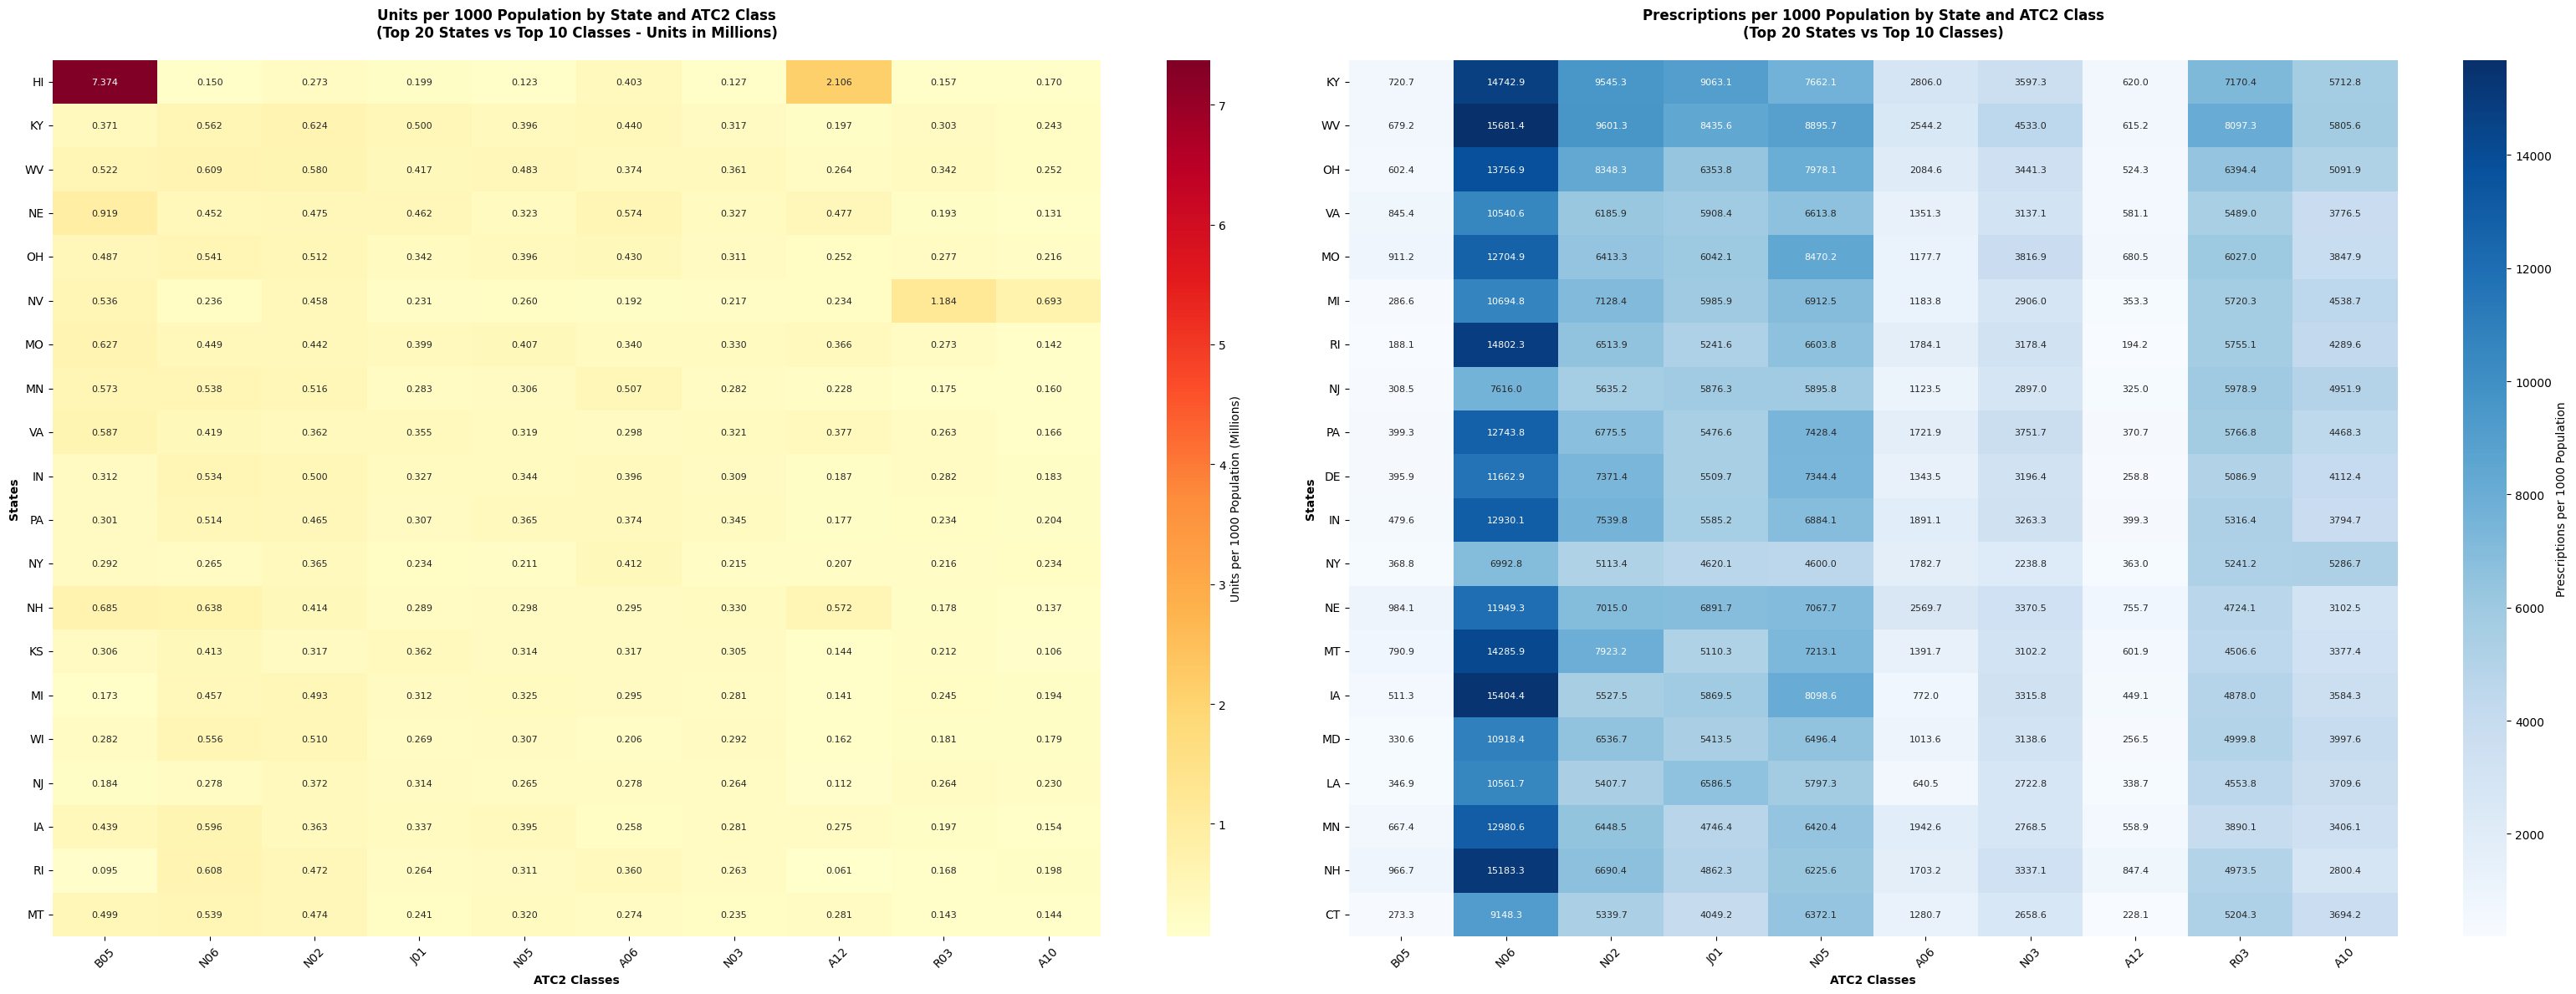


Creating detailed individual heatmaps...


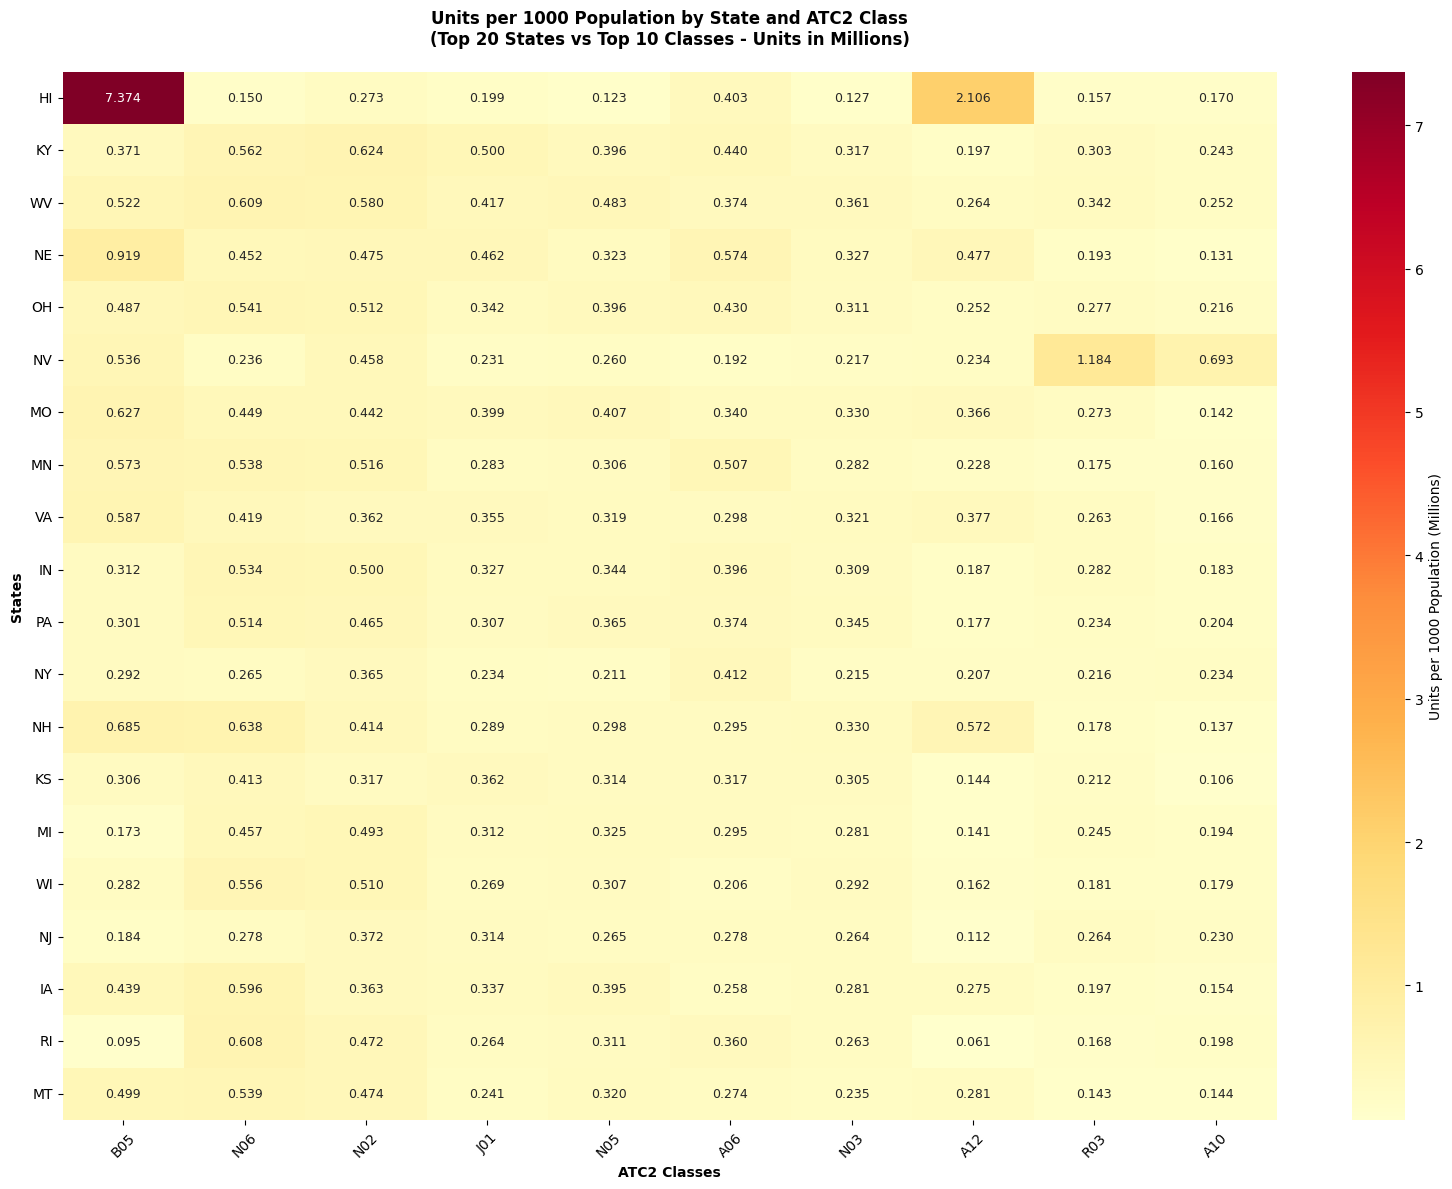

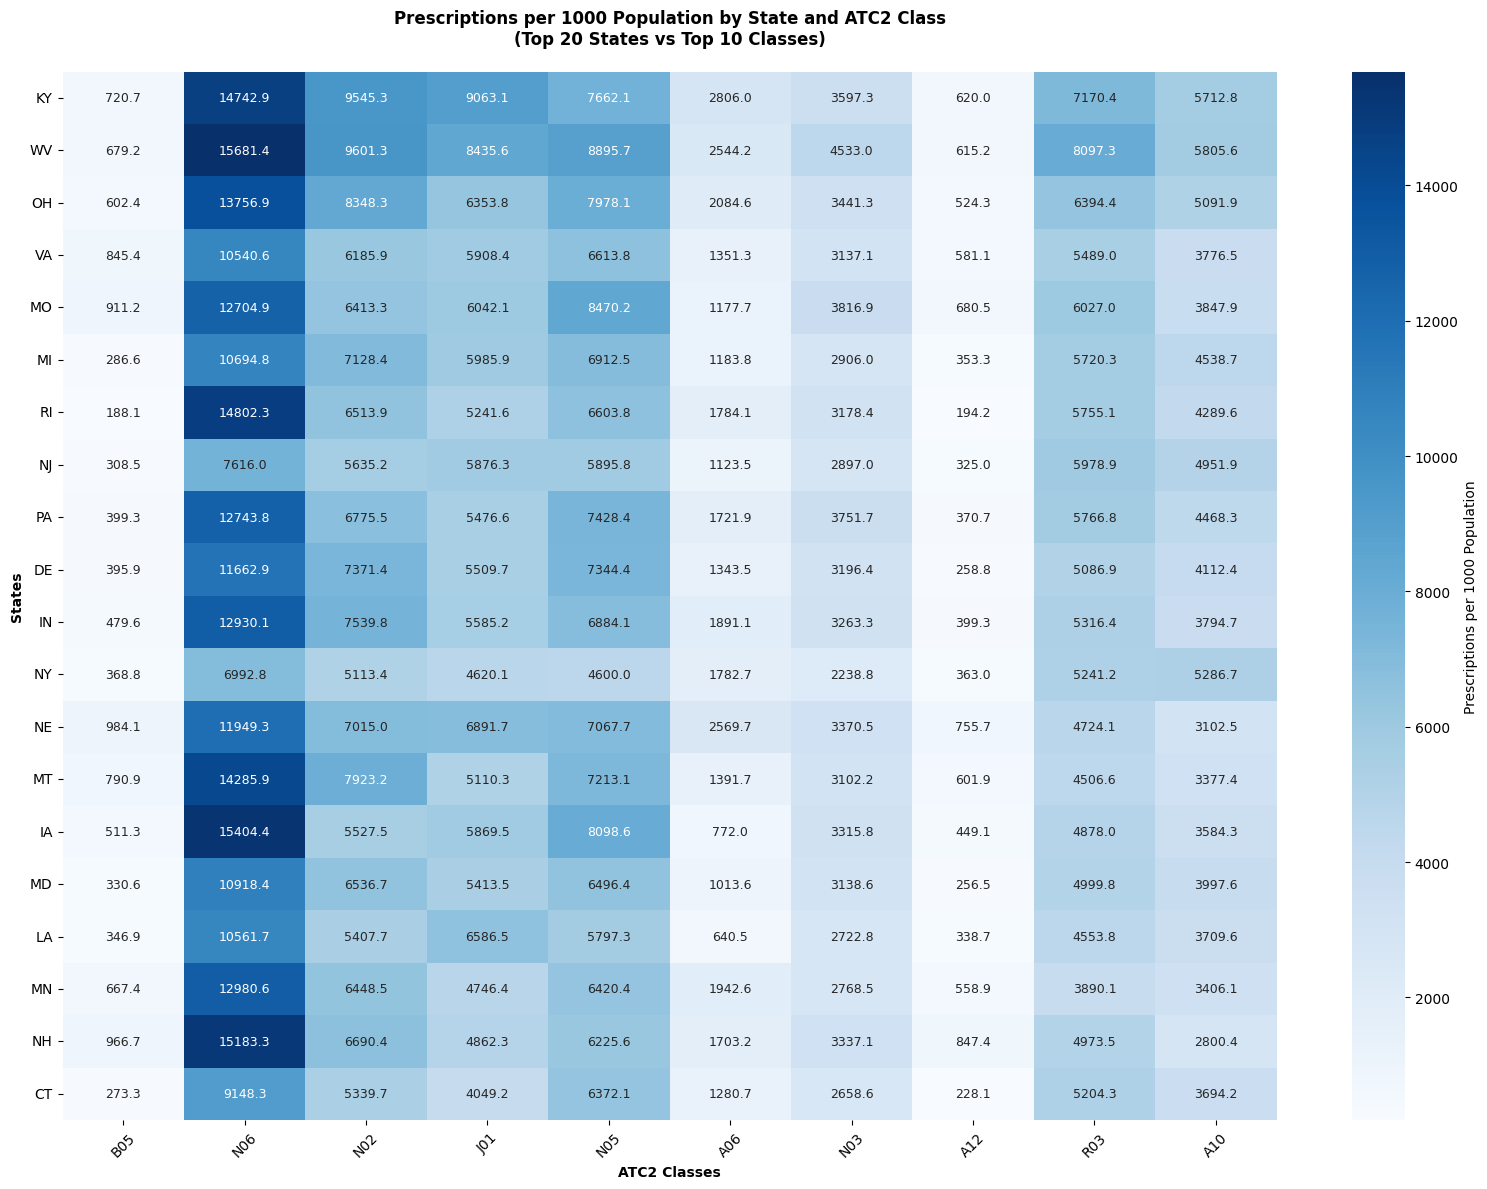


DETAILED ATC2 CLASS SUMMARY (POPULATION-NORMALIZED)
 1. B05
    Total: 25522975.2 units/1K population, 22633.1 rx/1K population
 2. N06
    Total: 20118219.7 units/1K population, 496710.9 rx/1K population
 3. N02
    Total: 18567545.2 units/1K population, 279776.6 rx/1K population
 4. J01
    Total: 15623551.7 units/1K population, 262427.0 rx/1K population
 5. N05
    Total: 13517602.4 units/1K population, 281638.9 rx/1K population
 6. A06
    Total: 13469123.1 units/1K population, 55622.6 rx/1K population
 7. N03
    Total: 12863626.2 units/1K population, 133267.9 rx/1K population
 8. A12
    Total: 11947841.8 units/1K population, 18790.4 rx/1K population
 9. R03
    Total: 10663424.5 units/1K population, 227083.2 rx/1K population
10. A10
    Total: 8026295.0 units/1K population, 163252.7 rx/1K population
11. S01
    Total: 6046801.3 units/1K population, 141414.1 rx/1K population
12. R06
    Total: 5932086.9 units/1K population, 97656.8 rx/1K population
13. A02
    Total: 5717999.8 u

In [16]:
pop_sdud = Pop_SDUD()

#merged_files = pop_sdud.merge_enroll()
#subpanel_df = pop_sdud.build_atc2_subpanel()

#This is only fo
pop_normalized_results = pop_sdud.analyze_top_states_by_pop_normalized_metrics(top_n_states=20, top_n_classes=15)
